In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Helper functions
def handle_infinite_values(data):
    if data.isin([np.inf, -np.inf]).any().any():
        infinite_values = data.isin([np.inf, -np.inf])
        rows_with_infinite = data[infinite_values.any(axis=1)]
        print(f"Count of Rows with Infinite Values: {len(rows_with_infinite)}")
        data = data.replace([np.inf, -np.inf], np.nan)
        print('Cleaning infinite values done.')
    else:
        print('No Infinite Values Present')
    return data

def handle_nan_values(data):
    print("Handling NaN values . . .")
    nan_cols = data.columns[data.isnull().any()].tolist()
    print(f"Columns with NaN values: {nan_cols}")
    print(f"Count of NaN values: {data.isnull().sum().sum()}")
    
    for col in nan_cols:
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col] = data[col].fillna(data[col].mean())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
    
    print("Cleaning NaN values done.")
    return data

def handle_duplicates(data):
    duplicates = data[data.duplicated(keep=False)]
    shape = data.shape
    if duplicates.empty:
        print("No duplicated records found.")
        return data

    print(f"Count of Duplicated Records: {len(duplicates)}")
    data = data.drop_duplicates(keep='first')
    new_shape = data.shape
    print(f"Removed duplicated records.\nShape Before Cleaning: {shape}, Shape After Cleaning: {new_shape}")
    return data

def custom_encode(data, column_name):
    unique_values = data[column_name].unique()
    print(f"Categories : {unique_values}")
    encoding_dict = {value: index for index, value in enumerate(unique_values)}
    data[column_name] = data[column_name].map(encoding_dict)
    print(f"Encoded categories in column '{column_name}'.")
    return data

# Load dataset
data = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")  # Replace with actual dataset path

# Preprocess column names (remove spaces)
data.columns = data.columns.str.strip()

# Data cleaning with the helper functions
data = handle_infinite_values(data)
data = handle_nan_values(data)
data = handle_duplicates(data)

# Encode the target label
data = custom_encode(data, 'Label')

# Feature-target split
X = data.drop('Label', axis=1)
y = data['Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Count of Rows with Infinite Values: 34
Cleaning infinite values done.
Handling NaN values . . .
Columns with NaN values: ['Flow Bytes/s', 'Flow Packets/s']
Count of NaN values: 68
Cleaning NaN values done.
Count of Duplicated Records: 3940
Removed duplicated records.
Shape Before Cleaning: (225745, 79), Shape After Cleaning: (223112, 79)
Categories : ['BENIGN' 'DDoS']
Encoded categories in column 'Label'.


In [2]:
from sklearn.utils import resample

# Address Class Imbalance
def balance_classes(X, y):
    # Combine X and y for resampling
    data = np.column_stack((X, y))
    majority_class = data[data[:, -1] == 0]  # Assume 0 is the majority class
    minority_class = data[data[:, -1] == 1]  # Assume 1 is the minority class

    # Oversample the minority class
    if len(minority_class) > 0:
        minority_oversampled = resample(minority_class,
                                        replace=True,
                                        n_samples=len(majority_class),
                                        random_state=42)
        balanced_data = np.vstack((majority_class, minority_oversampled))
        np.random.shuffle(balanced_data)
        return balanced_data[:, :-1], balanced_data[:, -1]
    else:
        print("No samples found for the minority class.")
        return X, y

# Apply resampling to training data
X_train_balanced, y_train_balanced = balance_classes(X_train_scaled, y_train)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define GP-WGAN Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize Generator and Discriminator
input_dim = X_train_balanced.shape[1]
hidden_dim = 64
noise_dim = 20  # Noise for adversarial disturbance

generator = Generator(input_dim + noise_dim, hidden_dim, input_dim)
discriminator = Discriminator(input_dim, hidden_dim)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_balanced)
y_train_tensor = torch.FloatTensor(y_train_balanced).reshape(-1, 1)


In [4]:
# Training loop for GP-WGAN
for epoch in range(500):
    noise = torch.randn(X_train_tensor.size(0), noise_dim)
    fake_data = generator(torch.cat((X_train_tensor, noise), dim=1))

    # Train Discriminator
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(X_train_tensor), torch.ones(X_train_tensor.size(0), 1))
    fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(X_train_tensor.size(0), 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Train Generator
    optimizer_g.zero_grad()
    g_loss = criterion(discriminator(fake_data), torch.ones(X_train_tensor.size(0), 1))
    g_loss.backward()
    optimizer_g.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/500], Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")


Epoch [100/1000], Loss D: 1.1742688417434692, Loss G: 0.6981019377708435
Epoch [200/1000], Loss D: 1.0862197875976562, Loss G: 0.6846858859062195
Epoch [300/1000], Loss D: 1.0494061708450317, Loss G: 0.7680466771125793
Epoch [400/1000], Loss D: 0.906957745552063, Loss G: 1.1349539756774902
Epoch [500/1000], Loss D: 0.9976103901863098, Loss G: 1.058070421218872



Classification Report for RandomForest:
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     76209
         1.0       1.00      0.00      0.00     76209

    accuracy                           0.50    152418
   macro avg       0.75      0.50      0.33    152418
weighted avg       0.75      0.50      0.33    152418

Accuracy of RandomForest: 0.50

Classification Report for KNN:
              precision    recall  f1-score   support

         0.0       0.50      0.96      0.66     76209
         1.0       0.56      0.05      0.09     76209

    accuracy                           0.51    152418
   macro avg       0.53      0.51      0.38    152418
weighted avg       0.53      0.51      0.38    152418

Accuracy of KNN: 0.51

Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.46      0.54      0.50     76209
         1.0       0.44      0.36      0.39     76209

    accuracy            

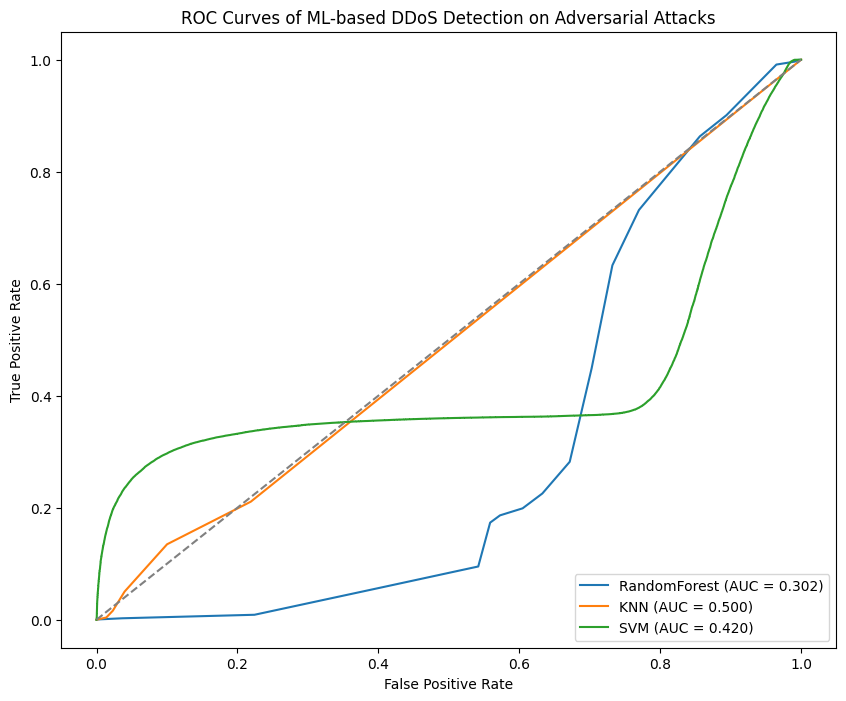

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Generate adversarial data for evaluation
noise = torch.randn(X_train_tensor.size(0), noise_dim)
adversarial_data = generator(torch.cat((X_train_tensor, noise), dim=1)).detach().numpy()

# Adjust y_test for evaluation consistency
y_test_adjusted = y_train_balanced[:len(adversarial_data)]

# ML-based detectors
models = {
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True)
}

# Fit models and evaluate
plt.figure(figsize=(10, 8))  # Increase figure size for clarity

for model_name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(adversarial_data)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test_adjusted, y_pred, zero_division=1))

    accuracy = accuracy_score(y_test_adjusted, y_pred)
    print(f"Accuracy of {model_name}: {accuracy:.2f}")

    # Calculate ROC curve
    try:
        y_proba = model.predict_proba(adversarial_data)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_adjusted, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
    except Exception as e:
        print(f"Error with ROC calculation for {model_name}: {str(e)}")

# Plot configuration
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curves of ML-based DDoS Detection on Adversarial Attacks')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


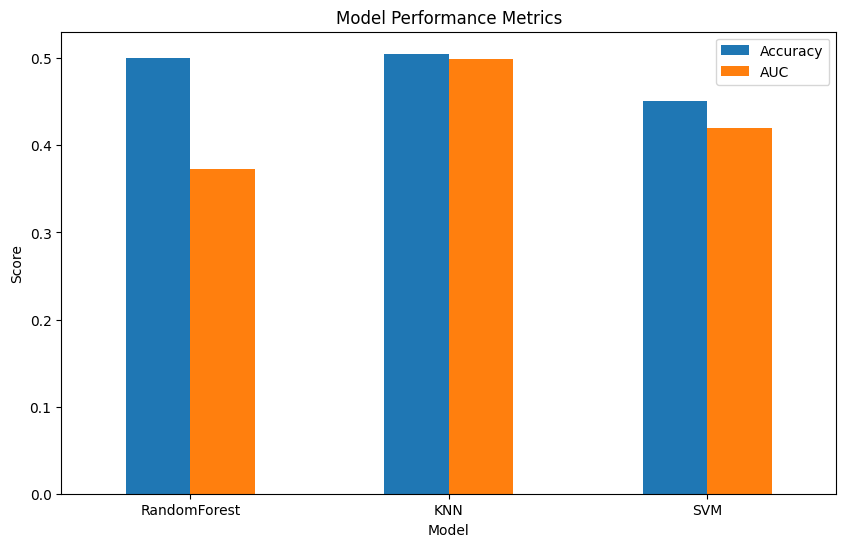

In [7]:
import pandas as pd

metrics = {'Model': [], 'Accuracy': [], 'AUC': []}
for model_name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(adversarial_data)
    accuracy = accuracy_score(y_test_adjusted, y_pred)
    try:
        y_proba = model.predict_proba(adversarial_data)[:, 1]
        roc_auc = auc(*roc_curve(y_test_adjusted, y_proba)[:2])
    except:
        roc_auc = None
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy)
    metrics['AUC'].append(roc_auc if roc_auc is not None else 0)

metrics_df = pd.DataFrame(metrics)
metrics_df.plot(x='Model', kind='bar', figsize=(10, 6), legend=True, rot=0)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()
